In [1]:
# requirements

!pip install requests
!pip install time
!pip install pandas
!pip install numpy
!pip install matplotlib.pyplot
!pip install schedule


ERROR: Could not find a version that satisfies the requirement time (from versions: none)
ERROR: No matching distribution found for time
ERROR: Could not find a version that satisfies the requirement matplotlib.pyplot (from versions: none)
ERROR: No matching distribution found for matplotlib.pyplot


# For Reviewers:
The purpose of our tutorial is to show how to make data-informed investment decisions through visualizing and analyzing past trends in cryptocurrencies and index fund(s). Our target users are beginner investors who are interested in crypto markets but have limited coding experience. We assume that the user will have a basic understanding of Python but limited exposure to data science. Our tutorial will address user needs like having accessibility of financial data analysis and practical decision making tools. Beginners will struggle to gather, clean, and visualize data so we will be providing step-by-step instructions for doing so. Also through seeing risk and reward tradeoffs and making a predictive AI model, users will gain skills in comparing assets and products and be able to experiment with financial strategies like holding and buying. Our tutorial will focus on data based coding while ensuring that users learn the concepts of financial data analysis and the workflows necessary to implement and visualize them.

The priorties for things to review at the high level would be our graphs. Our priorities is to make the graph(s) as clear as possible and the data cleaning step. We are also not sure if the numpy and pandas methods that we use are too advanced for our target audience.

Whats Done: We implemented getting the cryptocurrency data from an API, cleaning the data, calculaing the risk/reward from that data, graphing the data, and scheduling it so that the pipeline runs everyday at 9 am.

Whats missing/left to do is that we wanted to add an interactive element to the graph so that you can over specific dates on the graph and be able to see that days closing price/violatility. Additionally we still need write the call for an OpenAI LLM to give advice based on the prices/violatility. Finally, we still need to change the code so that multiple/different coins can be used instead of just bitcoin.

Additional Notes: All of the requirement libraries are listed above. For the scheduling code, you can change 09:00 to next closest minute in order to test that segment of code. 



In [2]:
import requests
import time

def fetch_data():
    coin_id = "bitcoin"
    url = f"https://api.coingecko.com/api/v3/coins/{coin_id}/market_chart/range"

    to_ts = int(time.time())                 
    from_ts = to_ts - 90 * 24 * 60 * 60    

    params = {    
        "vs_currency": "usd",
        "from": from_ts,
        "to": to_ts        
    }

    response = requests.get(url, params=params)
    data = response.json()

    # print(data)

    return data

# Section: Cleaning and Structuring Data
When we first pull cryptocurrency data from an API like CoinGecko, what we get isn’t something we can use right away.
It’s just long lists of numbers (timestamps and prices) that don’t look meaningful yet.

Before we can analyze anything, we need to clean and organize that data into something structured — ideally a table that tells us, for each day, what Bitcoin’s opening, high, low, and closing prices were, along with its trading volume.

Let’s start by importing the tools we’ll need.

For this tutorial We’ll use two key Python libraries that come up in almost any data project:

- pandas for working with data tables (called DataFrames)

- numpy for numerical operations and handling missing values

Lets import those to use and get our data using the fetch_data() function that we made in the last section.

In [ ]:
import pandas as pd
import numpy as np

coins = ["bitcoin", "ethereum"]
data_dict = {coin: fetch_data(coin) for coin in coins}

TypeError: fetch_data() takes 0 positional arguments but 1 was given

These lists hold pairs of numbers:

- The first number is a timestamp in milliseconds (Unix time).

- The second number is the recorded value.

Timestamps like 1731734282718 aren’t very readable, so our first job is to convert them into normal datetimes and organize everything in proper time order.

Let’s create a helper function that takes one of these lists and turns it into a clean table.

This function will:

- Create a DataFrame with labeled columns

- Convert the timestamps to readable UTC dates

- Sort everything by time

- Clean up bad or missing values

In [4]:
def _to_df(series, value_name):
    df = pd.DataFrame(series, columns=["ts_ms", value_name])
    df["date_utc"] = pd.to_datetime(df["ts_ms"], unit="ms", utc=True)
    df = df.drop(columns=["ts_ms"]).sort_values("date_utc")
    df[value_name] = pd.to_numeric(df[value_name], errors="coerce").replace(0, np.nan)
    return df


Price and volume are usually recorded at slightly different times, so we’ll need to align them.
To do that, we use pandas.merge_asof(), which matches each price with the nearest volume entry within a small window — here, 5 minutes.

In [5]:
def align_price_volume(data_json):
    prices_df = _to_df(data_json["prices"], "price")
    vols_df   = _to_df(data_json["total_volumes"], "vol_ccy")  # ccy = quote currency (e.g., USD)

    tick = pd.merge_asof(
        prices_df.sort_values("date_utc"),
        vols_df.sort_values("date_utc"),
        on="date_utc",
        direction="nearest",
        tolerance=pd.Timedelta("5min"),
    )

    # Fill small gaps and remove missing entries
    tick["price"] = tick["price"].ffill(limit=3)
    tick = tick.dropna(subset=["price", "vol_ccy"]).set_index("date_utc").sort_index()
    return tick

The next step is to summarize all this minute-by-minute data into a daily format.
In financial analysis, here are five key daily statistics that will help us see more detail for each daily data point:

- Open — first price of the day

- High — highest price of the day

- Low — lowest price of the day

- Close — last price of the day

- Volume — total traded amount that day

We can extract all of this with pandas’ resample() function.

In [6]:
def coingecko_to_daily_ohlcv(data_json):
    # Step 1: combine price and volume at tick level
    tick = align_price_volume(data_json)

    # Step 2: estimate traded volume in base units (e.g., BTC)
    tick["vol_base"] = tick["vol_ccy"] / tick["price"]

    # Step 3: compute daily OHLC
    ohlc = tick["price"].resample("1D").agg(
        Open="first",
        High="max",
        Low="min",
        Close="last"
    )

    # Step 4: compute total daily volume
    vols = tick.resample("1D").agg({
        "vol_base": "sum",
        "vol_ccy": "sum"
    }).rename(columns={
        "vol_base": "Volume (Base)",
        "vol_ccy": "Volume (Currency)"
    })

    # Step 5: merge and clean up
    daily = pd.concat([ohlc, vols], axis=1)
    daily.index.name = "Date"
    return daily.dropna(how="all")

In [ ]:
daily_data = {coin: coingecko_to_daily_ohlcv(data_dict[coin]) for coin in coins}

In [7]:
import numpy as np 
import math

# Sharp Ratio Grading Thresholds:
# Less than 1: Bad
# 1 – 1.99: Adequate/good
# 2 – 2.99: Very good
# Greater than 3: Excellent

# prices: array of prices
# rf: risk-free rate of return
def risk_return(prices, rf=0.04):
    returns = [((prices[i] - prices[i-1]) / prices[i-1]) for i in range(1, len(prices))]
    risk = np.std(returns)
    reward = np.mean(returns)
    return reward - rf / risk

print(risk_return(btc_daily["Close"]))

# over 90 days
def volatility(prices):
    returns = [((prices[i] - prices[i-1]) / prices[i-1]) for i in range(1, len(prices))]
    average = sum(returns) / len(returns)
    diffs = []
    for daily_return in returns:
        diffs.append((daily_return - average)**2)
    sd = [math.sqrt(diff/len(returns)) for diff in diffs]
    crypto_volatility = [round(n * math.sqrt(365) * 100, 2) for n in sd]
    return crypto_volatility

btc_volatility = volatility(btc_daily["Close"])
print(btc_volatility)

NameError: name 'btc_daily' is not defined

In [ ]:
import matplotlib.pyplot as plt

# def plot_graph(btc_daily):
#     plt.figure(figsize=(10,5))
#     plt.plot(btc_daily.index, btc_daily["Close"], label="BTC Daily Close")
#     plt.title("Bitcoin Daily Closing Prices")
#     plt.xlabel("Date")
#     plt.ylabel("Price (USD)")
#     plt.legend()
#     plt.show()

# def plot_risk_graph():
#     plt.figure(figsize=(10,5))
#     plt.plot(btc_daily["date"][1:], btc_volatility, color="blue", label="BTC Daily Volatility")
#     plt.title("Bitcoin Daily Volatility")
#     plt.xlabel("Date")
#     plt.ylabel("Volatility")
#     plt.legend()
#     plt.show()

def plot_combined_graph(btc_daily, btc_volatility):
    fig, ax1 = plt.subplots(figsize=(10, 5))

    ax1.plot(btc_daily.index, btc_daily["Close"], color="orange", label="BTC Daily Close")
    ax1.set_xlabel("Date")
    ax1.set_ylabel("Price (USD)", color="orange")
    ax1.tick_params(axis="y", labelcolor="orange")

    ax2 = ax1.twinx()
    ax2.plot(btc_daily.index[1:], btc_volatility, color="blue", label="BTC Volatility")
    ax2.set_ylabel("Volatility (%)", color="blue")
    ax2.tick_params(axis="y", labelcolor="blue")

    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines + lines2, labels + labels2, loc="upper left")

    plt.title("Bitcoin Daily Closing Price and Volatility")
    plt.tight_layout()
    plt.show()

/var/folders/n0/8kk1p2bs4_56mk71mqvwlbs40000gn/T/ipykernel_84785/1040983200.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  returns = [((prices[i] - prices[i-1]) / prices[i-1]) for i in range(1, len(prices))]


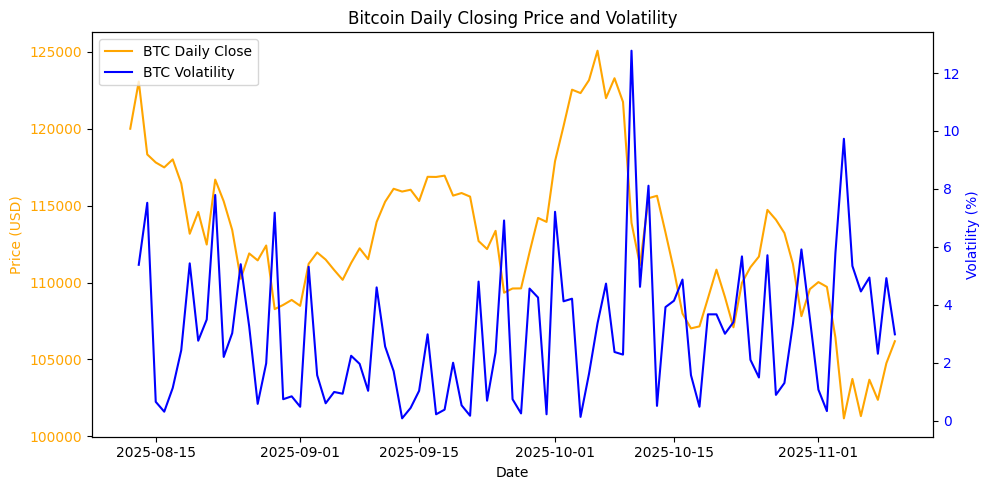

In [ ]:
import schedule
import requests
import time
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def schedule_graph():
    data = fetch_data()
    btc_daily = coingecko_to_daily_ohlcv(data)
    btc_volatility = volatility(btc_daily["Close"])
    plot_combined_graph(btc_daily, btc_volatility)

# schedule_graph()
    

schedule.every().day.at("09:00").do(schedule_graph)
print("Scheduler started. Will fetch and graph data every day at 09:00.")

while True:
    schedule.run_pending()
    time.sleep(60)